In [1]:
!pip install yfinance matplotlib scikit-learn


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Step 1: Download GHS/USD exchange rate data
# Yahoo Finance ticker for GHS/USD is "GHSUSD=X"
start = "2015-01-01"
end = "2025-06-01"
data = yf.download("USDGHS=X", start=start, end=end, interval="1d",auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.tail(10)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,USDGHS=X,USDGHS=X,USDGHS=X,USDGHS=X,USDGHS=X,USDGHS=X
Date,,,,,,
2025-05-19,12.393779,12.393779,12.280025,12.280025,12.280025,0
2025-05-20,12.280025,12.280025,12.331420,12.050000,12.331420,0
2025-05-21,12.050000,12.050000,12.121346,11.750000,12.121346,0
2025-05-22,11.750000,11.750000,11.889807,11.614073,11.889807,0
2025-05-23,11.614073,11.614073,11.031541,11.031541,11.031541,0
2025-05-26,11.009368,11.009368,11.000901,10.429313,11.000901,0
2025-05-27,10.429313,10.429313,10.413944,10.326880,10.413944,0
2025-05-28,10.326880,10.326880,10.336629,10.281253,10.336629,0


In [5]:
# keeping only the adj close price
# Keep only the 'Close' price
df = data[['Adj Close']].dropna()
df.rename(columns={'Adj Close': 'GHS_USD'}, inplace=True)

In [6]:
df.head()

Price,GHS_USD
Ticker,USDGHS=X
Date,
2015-01-01,3.1700
2015-01-02,3.2095
2015-01-05,3.1800
2015-01-06,3.1800
2015-01-07,3.1900


In [7]:
# Step 2: Feature engineering - create lag features (previous day prices)
df['Prev_Day'] = df['GHS_USD'].shift(1)
df['Prev_Week'] = df['GHS_USD'].shift(7)
df.dropna(inplace=True)

In [8]:
df.head()

Price,GHS_USD,Prev_Day,Prev_Week
Ticker,USDGHS=X,,
Date,,,
2015-01-12,3.2,3.2,3.1700
2015-01-13,3.2,3.2,3.2095
2015-01-14,3.2,3.2,3.1800
2015-01-15,3.2,3.2,3.1800
2015-01-16,3.2,3.2,3.1900


In [9]:
# Drop the first level of the column index (Ticker)
df.columns = df.columns.droplevel(1)

# Now df will have clean column names
print(df.head())

Price       GHS_USD  Prev_Day  Prev_Week
Date                                    
2015-01-12      3.2       3.2     3.1700
2015-01-13      3.2       3.2     3.2095
2015-01-14      3.2       3.2     3.1800
2015-01-15      3.2       3.2     3.1800
2015-01-16      3.2       3.2     3.1900


In [10]:
# Step 3: Train-test split
X = df[['Prev_Day', 'Prev_Week']]
y = df['GHS_USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error: 55.64380735914555
R² Score: -15.530986666992941


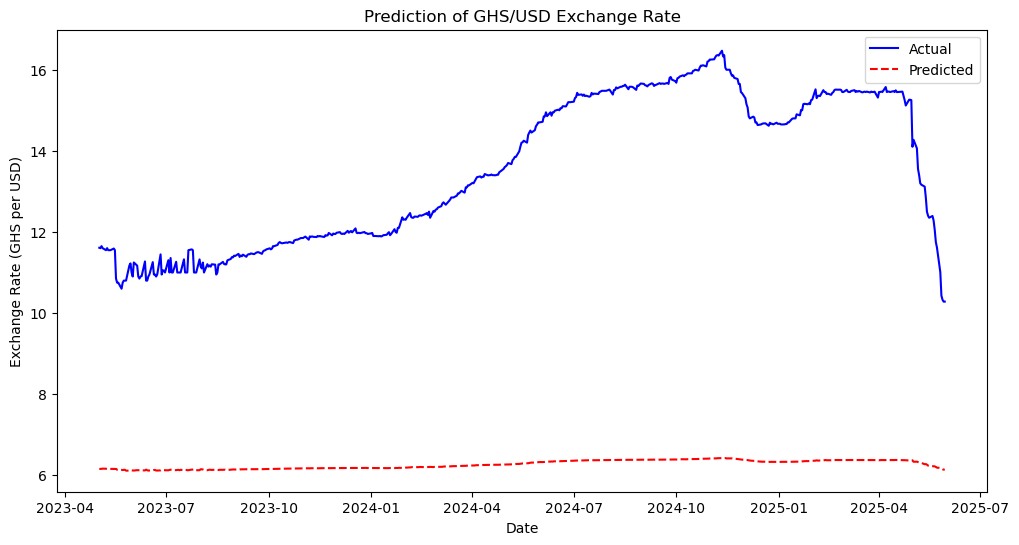

In [11]:
# Step 7: Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="dashed")
plt.title("Prediction of GHS/USD Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate (GHS per USD)")
plt.legend()
plt.savefig("ghs_usd_LinearReg_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# Manually set wrong value on 31st March 2020 to 5.73
df.loc['2020-03-31', 'GHS_USD'] = 5.73

In [13]:
!pip install pmdarima


In [14]:
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# ------------------------------
df.index = pd.to_datetime(df.index)

# Monthly and Weekly averages
monthly = df['GHS_USD'].resample('ME').mean().dropna()
weekly = df['GHS_USD'].resample('W').mean().dropna()



In [15]:
monthly.tail(10)

Date
2024-08-31    15.560305
2024-09-30    15.665015
2024-10-31    15.970328
2024-11-30    16.021335
2024-12-31    14.766930
2025-01-31    14.906936
2025-02-28    15.438407
2025-03-31    15.453888
2025-04-30    15.400603
2025-05-31    12.335481
Freq: ME, Name: GHS_USD, dtype: float64

In [16]:
values_only = monthly.loc["2020-02-02":"2020-07-01"].values
print(values_only)


[5.3544384  5.52627438 5.73007523 5.70895676 5.73545449]


In [17]:
values_only = weekly.loc["2020-02-02":"2020-07-01"].values
print(values_only)


[5.53600006 5.40933819 5.36441526 5.32200003 5.32200012 5.38599997
 5.47076769 5.53162622 5.64799995 5.7032134  5.72599993 5.75800009
 5.70033092 5.75600014 5.7420001  5.67799988 5.69799986 5.70761852
 5.70799999 5.76000004 5.72999983 5.74599991]


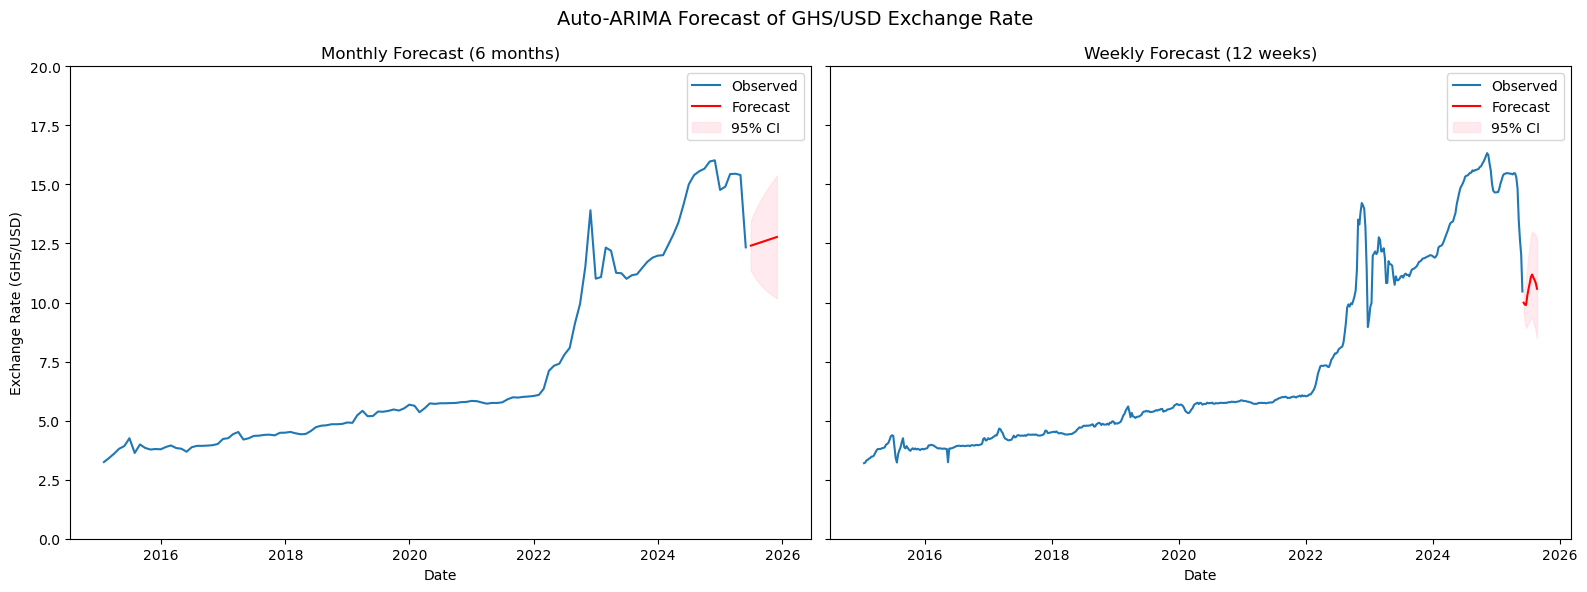

In [19]:
# ------------------------------
# Step 2. Fit Auto-ARIMA Models
# ------------------------------
# Monthly
auto_model_monthly = pm.auto_arima(monthly,
                                   seasonal=False,
                                   stepwise=True,
                                   suppress_warnings=True,
                                   error_action='ignore',
                                   max_p=5, max_q=5,
                                   d=None,
                                   trace=False)

# Weekly
auto_model_weekly = pm.auto_arima(weekly,
                                  seasonal=False,
                                  stepwise=True,
                                  suppress_warnings=True,
                                  error_action='ignore',
                                  max_p=5, max_q=5,
                                  d=None,
                                  trace=False)

# ------------------------------
# Step 3. Forecasts
# ------------------------------
# Monthly forecast (6 months ahead)
n_months = 6
forecast_m, conf_m = auto_model_monthly.predict(n_periods=n_months, return_conf_int=True)
forecast_index_m = pd.date_range(start=monthly.index[-1] + pd.offsets.MonthEnd(1),
                                 periods=n_months, freq='ME')
forecast_series_m = pd.Series(forecast_m, index=forecast_index_m)
conf_df_m = pd.DataFrame(conf_m, index=forecast_index_m, columns=["Lower", "Upper"])

# Weekly forecast (12 weeks ahead)
n_weeks = 12
forecast_w, conf_w = auto_model_weekly.predict(n_periods=n_weeks, return_conf_int=True)
forecast_index_w = pd.date_range(start=weekly.index[-1] + pd.offsets.Week(1),
                                 periods=n_weeks, freq='W')
forecast_series_w = pd.Series(forecast_w, index=forecast_index_w)
conf_df_w = pd.DataFrame(conf_w, index=forecast_index_w, columns=["Lower", "Upper"])

# ------------------------------
# Step 4. Visualization
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Monthly plot
axes[0].plot(monthly, label="Observed")
axes[0].plot(forecast_series_m, label="Forecast", color="red")
axes[0].fill_between(conf_df_m.index, conf_df_m["Lower"], conf_df_m["Upper"],
                     color="pink", alpha=0.3, label="95% CI")
axes[0].set_title("Monthly Forecast (6 months)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Exchange Rate (GHS/USD)")
axes[0].legend()
axes[0].set_ylim(0, 20)   

# Weekly plot
axes[1].plot(weekly, label="Observed")
axes[1].plot(forecast_series_w, label="Forecast", color="red")
axes[1].fill_between(conf_df_w.index, conf_df_w["Lower"], conf_df_w["Upper"],
                     color="pink", alpha=0.3, label="95% CI")
axes[1].set_title("Weekly Forecast (12 weeks)")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].set_ylim(0, 20)   

plt.suptitle("Auto-ARIMA Forecast of GHS/USD Exchange Rate", fontsize=14)
plt.tight_layout()
# Save the plot as PNG (before plt.show)

plt.savefig("ghs_usd_forecast.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()
